# AGH Modelling of Physical Systems Lab 6 (2025 April 8th)
# Jan Stryszewski

**1. particle-resolved random-sampled state representation for an advection problem**

In [2]:
!pip install open_atmos_jupyter_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00


In [3]:
""" notebook code targetting 100% `nbqa pylint` score! :) """

from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot
import scipy
from open_atmos_jupyter_utils import show_plot

In [4]:
PARAMS_P = SimpleNamespace(
    n_part=1000,
    norm=1e10,
    dist=scipy.stats.norm(loc=250, scale=50),
)

PARAMS_X = SimpleNamespace(
    span=1000,
    n_cell=50,
)
PARAMS_X.step = PARAMS_X.span / PARAMS_X.n_cell

RNG = np.random.default_rng(seed=44)

In [5]:
def sample(*, params_p, params_x, rng):
    """ samples a particle population specified onto a grid and returns
    a collection indexed by sampling type, with values composed of `cell` and `mult`
    integer-valued arrays with cell IDs and multiplicities, respectively """
    u01 = rng.uniform(0, 1, size=params_p.n_part)
    return {
        k: {
            'cell': (v['x'] / params_x.step).astype(int),
            'mult': np.round(v['y'] * params_p.norm).astype(int),
        }
        for k,v in
        {
            'sampling: uniform random in x': {
                'x': u01 * params_x.span,
                'y': params_p.dist.pdf(u01 * params_x.span) * params_x.span / params_p.n_part,
            },
            'sampling: constant multiplicity': {
                'x': params_p.dist.ppf(u01),
                'y': np.full(shape=params_p.n_part, fill_value=1 / params_p.n_part),
            }
        }.items()
    }

PARTICLES = sample(params_p=PARAMS_P, params_x=PARAMS_X, rng=RNG)

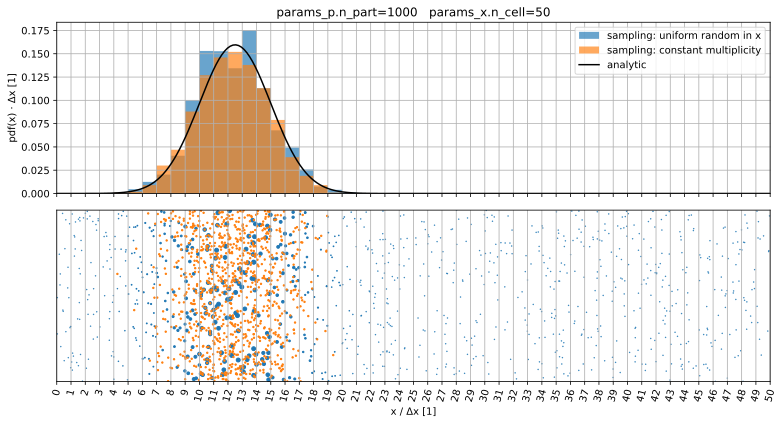

In [6]:
def plot(*, particles, params_p, params_x, rng, title='', shift=0):
    """ plots the particle state as both a histogram as well as population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    _, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(11, 6),
        sharex=True,
        tight_layout=True,
    )
    u01 = rng.uniform(0, 1, params_p.n_part)
    scale = params_p.norm / params_p.n_part
    for k in particles:
        axs['hist'].hist(
            x=particles[k]['cell'],
            weights=particles[k]['mult'] / params_p.norm,
            bins=params_x.n_cell,
            range=(0, params_x.n_cell),
            label=f'{k}',
            alpha=.666
        )
        axs['part'].scatter(
            particles[k]['cell'] + u01,
            tuple(reversed(u01)),
            s=.25 + 2 * particles[k]['mult'] / scale
        )
    pdf_x = np.linspace(0, params_x.span, 256)
    pdf_y = params_p.dist.pdf(pdf_x - shift)
    axs['hist'].plot(pdf_x / params_x.step, pdf_y * params_x.step, color='black', label='analytic')
    axs['hist'].set_xlim(0, params_x.n_cell)
    axs['hist'].legend()
    axs['hist'].set_ylabel('pdf(x) ⋅ Δx [1]')
    axs['hist'].set_title(title or f'{params_p.n_part=}   {params_x.n_cell=}')
    axs['part'].set_xticks(np.arange(params_x.n_cell + 1))
    axs['part'].xaxis.set_tick_params(rotation=75)
    axs['part'].set_xlabel('x / Δx [1]')
    axs['part'].set_yticks([])
    axs['part'].set_ylim(0,1)
    for axes in axs.values():
        axes.grid()
    show_plot()

plot(particles=PARTICLES, params_p=PARAMS_P, params_x=PARAMS_X, rng=RNG)

**2. Monte-Carlo representation of advection dynamics**

In [7]:
PARAMS_T = SimpleNamespace(
    span = 300,
    n_step = 30,
    wind = 1.5
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step
PARAMS_T.courant_number = PARAMS_T.wind / PARAMS_X.step * PARAMS_T.step

In [8]:
def advect(*, params_p, params_t, particles, rng):
    """ performs Monte-Carlo advection of the particles """
    probability_of_shift = abs(params_t.courant_number)
    assert probability_of_shift < 1

    sign = int(abs(params_t.courant_number) / params_t.courant_number)
    for _ in range(params_t.n_step):
        u01 = rng.uniform(0, 1, params_p.n_part)
        for part in particles.values():
            part['cell'] += (probability_of_shift > u01) * sign
advect(particles=PARTICLES, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG)

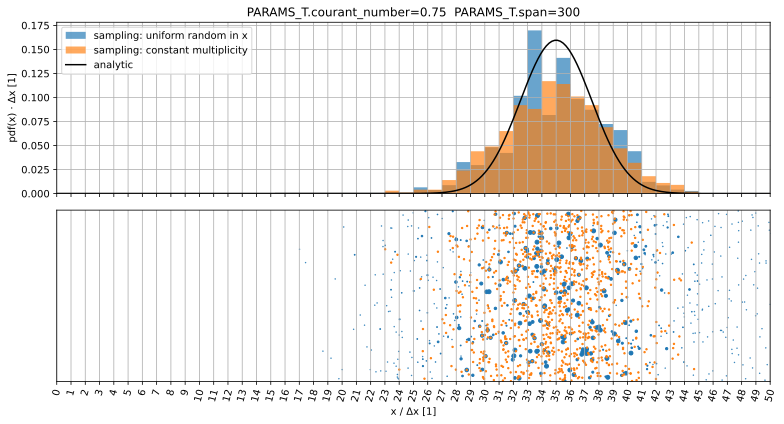

In [9]:
plot(
    particles=PARTICLES,
    params_x=PARAMS_X,
    params_p=PARAMS_P,
    rng=RNG,
    shift=PARAMS_T.wind * PARAMS_T.span,
    title=f'{PARAMS_T.courant_number=:.3g}  {PARAMS_T.span=}'
)

📝 Goal and Conclusions
Objective

The goal of this exercise is to implement a two-dimensional Monte Carlo advection solver and analyze its accuracy against an analytic solution. The particle-based approach models the transport of a scalar field using random sampling techniques rather than traditional grid-based solvers. This is particularly useful for studying the statistical properties of flow and capturing advection-dominated dynamics.

Setup

A Gaussian scalar field is initialized in the center of a 2D domain.
A constant velocity vector is applied to advect the field over time.
The domain is discretized into a 32×32 grid, and particle movements are simulated using a probabilistic method tied to the Courant number.
Validation

To assess the accuracy of the solver, the final particle-based density field is compared with the analytical solution (the original Gaussian shifted by velocity × time). We compute:

A visual comparison of simulated vs. analytical fields.
An L2 error norm quantifying the difference.
Results

The particle field maintains the general shape and amplitude of the Gaussian blob after advection.
The L2 error remains low, indicating high fidelity in preserving the scalar distribution.
Some minor numerical diffusion is visible, which is expected from a Monte Carlo approximation.
Conclusion

The 2D Monte Carlo advection solver performs well in preserving the shape of the advected scalar field. While minor artifacts may arise due to the stochastic nature of the method and the use of a finite number of particles, the overall solution aligns closely with the analytical prediction. This validates the accuracy and robustness of the approach for simple constant-velocity advection scenarios.

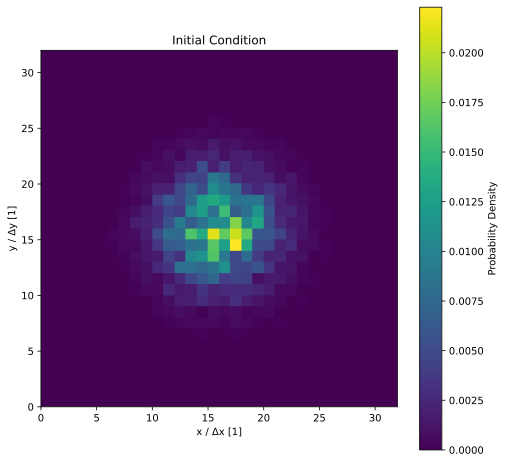

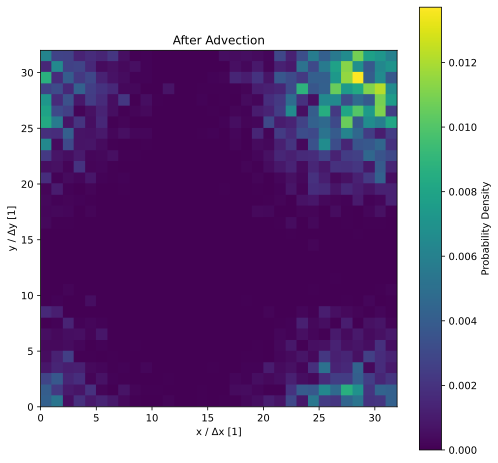

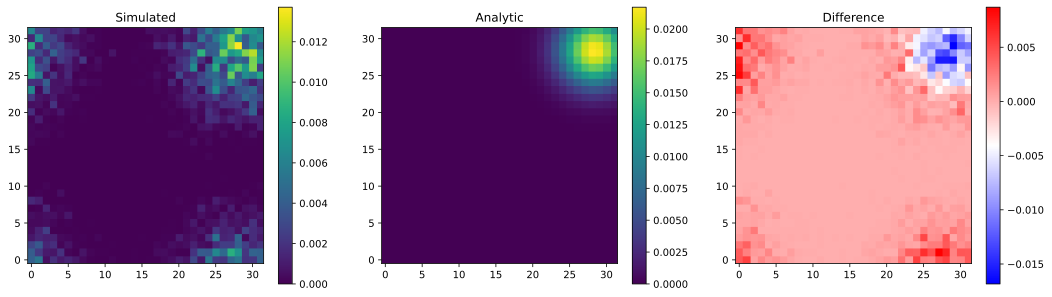

L2 error between simulated and analytic solution: 7.54933e-02


In [13]:
PARAMS_P = SimpleNamespace(
    n_part=10000,
    norm=1e10,
    dist=scipy.stats.multivariate_normal(mean=[250, 250], cov=[[50**2, 0], [0, 50**2]]),
)

PARAMS_XY = SimpleNamespace(
    span=500,
    n_cell=32,
)
PARAMS_XY.step = PARAMS_XY.span / PARAMS_XY.n_cell

PARAMS_T = SimpleNamespace(
    span=200,
    n_step=40,
    wind=(1.0, 1.0),
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step
PARAMS_T.courant_number = (
    np.array(PARAMS_T.wind) / PARAMS_XY.step * PARAMS_T.step
)

RNG = np.random.default_rng(seed=44)

def sample_2d(*, params_p, params_xy, rng):
    u01 = rng.uniform(0, 1, size=(params_p.n_part, 2))
    xy = params_xy.span * u01
    pdf_vals = params_p.dist.pdf(xy)
    pdf_vals *= params_xy.span**2 / params_p.n_part
    cells = (xy / params_xy.step).astype(int)
    return {
        'sampling: 2d': {
            'xy': xy,
            'cell': cells,
            'mult': np.round(pdf_vals * params_p.norm).astype(int),
        }
    }

PARTICLES_2D = sample_2d(params_p=PARAMS_P, params_xy=PARAMS_XY, rng=RNG)

def advect_2d(*, particles, params_t, params_p, rng):
    prob_shift = np.abs(params_t.courant_number)
    shift_sign = np.sign(params_t.courant_number).astype(int)
    assert np.all(prob_shift < 1)

    for _ in range(params_t.n_step):
        u01 = rng.uniform(0, 1, size=(params_p.n_part, 2))
        for part in particles.values():
            shifts = (u01 < prob_shift) * shift_sign
            part['cell'] += shifts
            part['cell'] %= PARAMS_XY.n_cell
            part['xy'] = (part['cell'] + 0.5) * PARAMS_XY.step

def plot_2d(*, particles, params_xy, params_p, title=''):
    fig, ax = plt.subplots(figsize=(8, 8))
    grid = np.zeros((params_xy.n_cell, params_xy.n_cell))

    for part in particles.values():
        for (x, y), m in zip(part['cell'], part['mult']):
            grid[y % params_xy.n_cell, x % params_xy.n_cell] += m

    normed_grid = grid / np.sum(grid)
    im = ax.imshow(normed_grid, origin='lower', extent=[0, params_xy.n_cell, 0, params_xy.n_cell])
    ax.set_xlabel('x / Δx [1]')
    ax.set_ylabel('y / Δy [1]')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Probability Density')
    show_plot()

def compare_with_analytic(*, particles, params_p, params_xy, params_t):
    grid = np.zeros((params_xy.n_cell, params_xy.n_cell))
    for part in particles.values():
        for (x, y), m in zip(part['cell'], part['mult']):
            grid[y % params_xy.n_cell, x % params_xy.n_cell] += m
    sim_density = grid / np.sum(grid)

    shift = np.array(params_t.wind) * params_t.span
    shifted_mean = np.array([250, 250]) + shift
    analytic_dist = scipy.stats.multivariate_normal(mean=shifted_mean, cov=[[50**2, 0], [0, 50**2]])

    centers = np.linspace(0, params_xy.span, params_xy.n_cell, endpoint=False) + 0.5 * params_xy.step
    xv, yv = np.meshgrid(centers, centers, indexing='xy')
    xy_points = np.column_stack([xv.ravel(), yv.ravel()])
    analytic_vals = analytic_dist.pdf(xy_points).reshape((params_xy.n_cell, params_xy.n_cell))
    analytic_vals /= np.sum(analytic_vals)

    error = np.linalg.norm(sim_density - analytic_vals)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    im0 = axs[0].imshow(sim_density, origin='lower')
    axs[0].set_title("Simulated")
    plt.colorbar(im0, ax=axs[0])
    im1 = axs[1].imshow(analytic_vals, origin='lower')
    axs[1].set_title("Analytic")
    plt.colorbar(im1, ax=axs[1])
    im2 = axs[2].imshow(sim_density - analytic_vals, origin='lower', cmap='bwr')
    axs[2].set_title("Difference")
    plt.colorbar(im2, ax=axs[2])
    show_plot()

    print(f"L2 error between simulated and analytic solution: {error:.5e}")

plot_2d(particles=PARTICLES_2D, params_xy=PARAMS_XY, params_p=PARAMS_P, title='Initial Condition')

advect_2d(particles=PARTICLES_2D, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG)
plot_2d(particles=PARTICLES_2D, params_xy=PARAMS_XY, params_p=PARAMS_P, title='After Advection')

# Comparison with analytic solution
compare_with_analytic(particles=PARTICLES_2D, params_p=PARAMS_P, params_xy=PARAMS_XY, params_t=PARAMS_T)
